In [14]:
from LinesCrawler import LineCrawler
import networkx as nx
import matplotlib.pyplot as plt
import re


 Created a `crawler` class to help scrape data in a BFS manner.

In [15]:
def retrieveEdges(start_url):
    """
    A breadth first search to scrape information from baike.baidu.com
    @start_url: `string`, url to start with.
    @return: `dict(string, int)`, dictionary[name, pair of stations]
    """
    edge_list = {}
    queue = [start_url]
    seen = set()

    while queue:
        curr = queue.pop(0)
        if not curr or curr in seen:
            continue
        print(curr)
        curr_crawler = LineCrawler(curr)
        if curr_crawler.stations is not None:
            edge_list[curr_crawler.name] = dict(curr_crawler.stations)
        if curr_crawler.next is not None:
            queue.extend(curr_crawler.next)
        seen.add(curr_crawler.url)
    return edge_list


In [16]:
# get edge_list
start_url = "https://baike.baidu.com/item/北京地铁1号线"
edge_list = retrieveEdges(start_url)
edge_list = {name: edges for name, edges in edge_list.items() if edges}


https://baike.baidu.com/item/北京地铁1号线
https://baike.baidu.com/item/%E5%8C%97%E4%BA%AC%E5%9C%B0%E9%93%816%E5%8F%B7%E7%BA%BF
https://baike.baidu.com/item/%E5%8C%97%E4%BA%AC%E5%9C%B0%E9%93%8118%E5%8F%B7%E7%BA%BF
https://baike.baidu.com/item/%E5%8C%97%E4%BA%AC%E5%9C%B0%E9%93%8110%E5%8F%B7%E7%BA%BF
https://baike.baidu.com/item/%E5%8C%97%E4%BA%AC%E5%9C%B0%E9%93%819%E5%8F%B7%E7%BA%BF
https://baike.baidu.com/item/%E5%8C%97%E4%BA%AC%E5%9C%B0%E9%93%8116%E5%8F%B7%E7%BA%BF
https://baike.baidu.com/item/%E5%8C%97%E4%BA%AC%E5%9C%B0%E9%93%8118%E5%8F%B7%E7%BA%BF/585770
https://baike.baidu.com/item/%E5%8C%97%E4%BA%AC%E5%9C%B0%E9%93%812%E5%8F%B7%E7%BA%BF
https://baike.baidu.com/item/%E5%8C%97%E4%BA%AC%E5%9C%B0%E9%93%8119%E5%8F%B7%E7%BA%BF
https://baike.baidu.com/item/%E5%8C%97%E4%BA%AC%E5%9C%B0%E9%93%814%E5%8F%B7%E7%BA%BF
https://baike.baidu.com/item/%E5%8C%97%E4%BA%AC%E5%9C%B0%E9%93%818%E5%8F%B7%E7%BA%BF
https://baike.baidu.com/item/%E5%8C%97%E4%BA%AC%E5%9C%B0%E9%93%815%E5%8F%B7%E7%BA%BF
https://baike.ba

 Three types of graphs
   * connection_graph: relationship between pair of stations
   * distance_graph: `distance` between pair of stations
   * transfer_graph: name of line where the pair of stations were on.

In [17]:
def build_graph_connection(edge_list):
    """
    @edge_list: `List(Tuple(string))`, List of tuples of stations that are adjacent in some line
    @return: `dict(string, string)`, a mapping from station to station
    """
    graph = {}
    for i, j in edge_list:
        graph[i] = graph.get(i, []) + [j]
        graph[j] = graph.get(j, []) + [i]
    return graph

def build_graph_transfer(edge_list):
    """
    @edge_list: `List(tuple(string))`, List of tuples of stations that are adjacent in some line
    @return: `dict(`string`, `string`)`, a mapping from `pair` of stations to name of raillines
    """
    graph = {}
    for i in edge_list:
        for j in edge_list[i]:
            graph[j] = i
    return graph


In [18]:
# build graphs: distance graph - determine the distance between pair of stations
distance_edge_list = {}
for edges in edge_list.values():
    distance_edge_list.update(edges)
distance_edge_list = {pair: float(re.match('[0-9]+', dist).group()) for pair, dist in distance_edge_list.items()
                      if re.match('[0-9]+', dist)}

# maping of station pair -> distance
distance_graph = {pair: dist * 1000 if dist < 10 else dist for pair, dist in distance_edge_list.items()}

# maping of station -> station
connection_graph = build_graph_connection([pair.split('——') for pair in distance_edge_list.keys()])

# build graphs: transfer graph - determine whether two stations on same line
transfer_edge_list = {name: [i for i in pair.keys() if '——' in i] for name, pair in edge_list.items()}

# maping of station pair -> name of lines
transfer_graph = build_graph_transfer(transfer_edge_list)


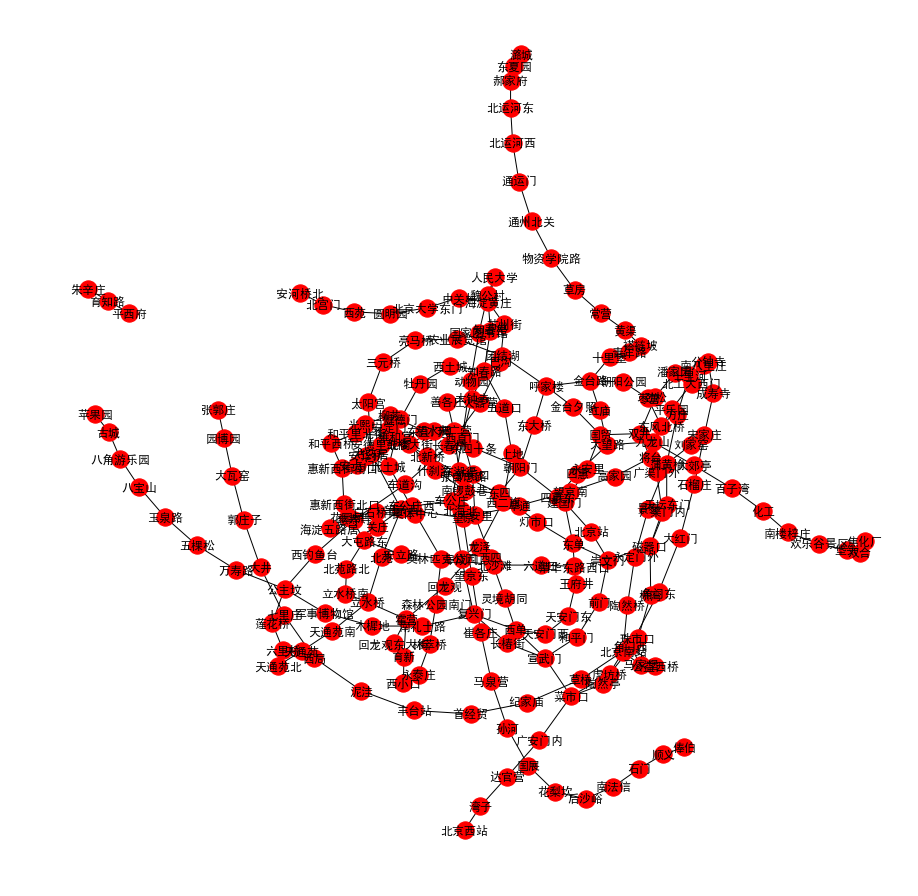

In [30]:
# create graph with weighted edges
pairs = [i.split('——') for i in distance_graph.keys()]
G = nx.Graph()
G.add_edges_from(pairs)
plt.figure(3,figsize=(12,12)) 
nx.draw(G, with_labels=True, pos=nx.spring_layout(G))


 ## Search agent
 At every iteration in BFS, `pathes` will be reordered so that the most proritized `path` will be
 placed at front. I created a object called `cost` as a abstract term to be used as key for prioritizing.
 Once a `path` is placed prior to others in `pathes`, it must have smallest `cost` under the strategy.
      * In distance: `cost` is equivalent to `distance`
      * In transfer: `cost` is equivalent to number of transfers to be made
      * Since two types of `cost` are in different scales, in the overall policy, I will let `tranfer_cost` time 5000.

 For search_agent with `by_way`, I literally start from finding optimal path from `start` to any one in `by_way`.
 then the path to `destination`.


In [33]:
# build search engine
def is_goal_varnilla(destination, path):
    """
    @path: `List(string)`, 
    @destination: `string` 
    @return: `bool`, whether the path met the goal
    """
    return path[-1] == destination

def cost_distance(x, y):
    """
    compute the cost based on distance between stations
    @x: `string`, current station
    @y: `List(string)`, current sequence of stations
    @return: `float`, cost when adding station to the current sequence
    """
    return distance_graph.get('{}——{}'.format(x, y[-1]), 0) + distance_graph.get('{}——{}'.format(y[-1], x), 0)

def cost_transfer(x, y):
    """
    compute the cost based on number of transfer between stations
    @x: `string`, current station
    @y: `List(string)`, current sequence of stations
    @return: `int`, cost when adding station to the current sequence
    """
    if len(y) < 2:
        return 0
    if '{}——{}'.format(x, y[-1]) in transfer_graph:
        tmp1 = transfer_graph['{}——{}'.format(x, y[-1])]
    else:
        tmp1 = transfer_graph['{}——{}'.format(y[-1], x)]

    if '{}——{}'.format(y[-2], y[-1]) in transfer_graph:
        tmp2 = transfer_graph['{}——{}'.format(y[-2], y[-1])]
    else:
        tmp2 = transfer_graph['{}——{}'.format(y[-1], y[-2])]

    if tmp1 != tmp2:
        return 1
    else:
        return 0

def cost_overall(x, y):
    """
    compute the overall cost based on both Transfer and distance.
    @x: `string`, current station
    @y: `List(string)`, current sequence of stations
    @return: `int`, cost when adding station to the current sequence
    """
    return cost_distance(x, y) + cost_transfer(x, y) * 5000

class search(object):
    def search(self, graph, start, destination, strategy_function, is_goal=is_goal_varnilla):
        """
        search method to find path between `start` and `destination` when `by_way` is empty
        @strategy_function: `function`, function/method to compute cost when adding station to sequence
        @is_goal: `function`, determine whether the goal has been met.
        @return: `List(String)`, 
        """
        global pathes
        pathes = [([start], 0)]
        seen = set()

        while pathes:
            path, cost = pathes.pop(0)
            frontier = path[-1]

            if frontier in seen:
                continue
            successors = graph[frontier]

            for station in successors:
                if station in seen:
                    continue
                new_path = path + [station]
                new_cost = cost + strategy_function(station, path)

                pathes.append((new_path, new_cost))
                if is_goal(destination, new_path):
                    return new_path
            seen.add(frontier)
            pathes.sort(key=lambda x: x[1])

    def search_by_way(self, graph, start, destination, strategy_function, by_way, is_goal=is_goal_varnilla):
        """
        search method to find path given non-empty `by_way`
        @...
        """
        path = []
        by_way.append(destination)
        for city in by_way:
            if city in path:
                continue
            path += self.search(graph, start, city, strategy_function, is_goal)[:-1]
            start = city
        return path + [destination]


In [34]:
# test case: distance priority
start, destination = '西二旗', '奥林匹克公园'
by_way = ['立水桥', '大屯路东']
ans = search().search(connection_graph, start, destination, strategy_function=cost_distance)
print('distance_first', ans)
ans2 = search().search(connection_graph, start, destination, strategy_function=cost_transfer)
print('transfer_first', ans2)
ans3 = search().search(connection_graph, start, destination, strategy_function=cost_overall)
print('overall_first', ans3)
ans4 = search().search_by_way(connection_graph, start, destination, by_way=by_way, strategy_function=cost_distance, is_goal=is_goal_varnilla)
print('by_way_first', ans4)


distance_first ['西二旗', '上地', '五道口', '知春路', '西土城', '牡丹园', '健德门', '北土城', '奥体中心', '奥林匹克公园']
transfer_first ['西二旗', '龙泽', '回龙观', '霍营', '立水桥', '北苑', '望京西', '关庄', '大屯路东', '安立路', '奥林匹克公园']
overall_first ['西二旗', '龙泽', '回龙观', '霍营', '育新', '西小口', '永泰庄', '林萃桥', '森林公园南门', '奥林匹克公园']
by_way_first ['西二旗', '龙泽', '回龙观', '霍营', '立水桥', '立水桥南', '北苑路北', '大屯路东', '安立路', '奥林匹克公园']


 ## Compare to baidu map
 时间短： 西二旗 -> 知春路 -> 北土城 -> 奥体中心 ->（步行）-> 奥林匹克公园

 少换程： 西二旗 -> 霍营 -> 奥体中心 ->(步行)-> 奥林匹克公园

 推荐路线： 西二旗 -> 霍营 -> 奥体中心 ->(步行)-> 奥林匹克公园

 ## 分析对比：
 `时间短`对应 `cost_distance` 距离短优先，二者结果基本一致，除了百度地图里推荐在奥体中心站下车（应该是离公园大门更近）。

 `少换程`对应 `cost_transfer` 少换乘优先，这里存在差异，百度地图选择了13号线转8号线，而我的程序优先选了13号-5号线，2者在换成方面优先级一致。但是百度推荐的时间更短

 `推荐路线`对应`cost_overall` 综合考虑，在这里两程序结果一致。

 总的来说，百度地图应该是将时间（距离）和换乘次数同时作为指标进行考虑，在不同需求下指标的优先级不同，但是在当主要指标等价时会将另一指标作为备选来排序。
 而百度的推荐路线就是设定一个函数，同时将二者考虑计算出一个新的量化指标，用来进行综合考量。